# Assignment #3: Model validation on the Iris dataset

In [95]:
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

## Load data

In [96]:
def read_in_and_split_data(iris_data):
    data = iris_data['data']
    targets = iris_data['target']
    return model_selection.train_test_split(data, targets, test_size=0.1)

iris_data = datasets.load_iris()

train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

# Convert targets to a one-hot encoding
train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

## Build model

In [97]:
def get_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape, kernel_initializer='he_uniform', bias_initializer='ones'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

model = get_model(train_data[0].shape)

## Compile model

In [98]:
def compile_model(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(model)

## Train model

In [99]:
def train_model(model, train_data, train_targets, epochs):
    return model.fit(train_data, train_targets, epochs=epochs, validation_split=0.15, batch_size=40, verbose=0)

history = train_model(model, train_data, train_targets, epochs=800)

## Plot learning

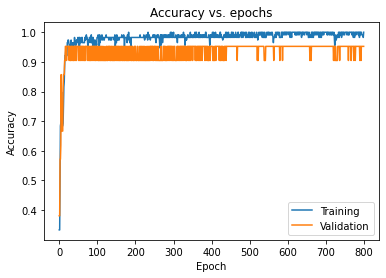

In [100]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

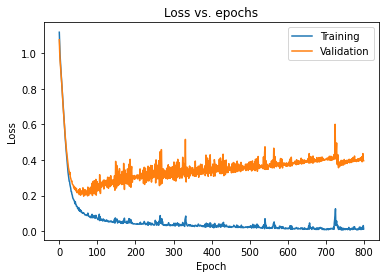

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Evaluate model

In [102]:
test_loss, test_acc = model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.009
Test accuracy: 100.00%


## Build regularized model (to reduce overfitting)

In [103]:
def get_regularised_model(input_shape, dropout_rate, weight_decay):
    model = Sequential([
        Dense(64, activation='relu', 
                  input_shape=input_shape, 
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=regularizers.l2(weight_decay), 
                  bias_initializer='ones'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(3, activation='softmax')
    ])
    return model

reg_model = get_regularised_model(train_data[0].shape, 0.3, 0.001)

compile_model(reg_model)

reg_history = train_model(reg_model, train_data, train_targets, epochs=800)

## Plot learning

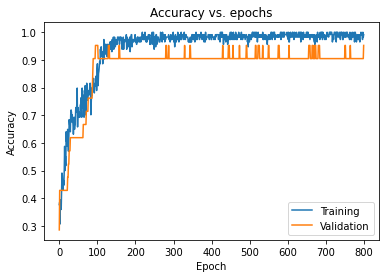

In [104]:
try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

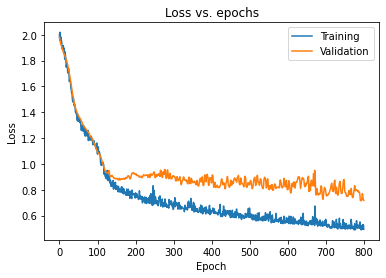

In [105]:
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Evaluate model

In [106]:
test_loss, test_acc = reg_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.478
Test accuracy: 100.00%


## Use callbacks for early stopping

In [107]:
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks should be instantiated according to the above requirements.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30)
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=20)
    return early_stopping, learning_rate_reduction
    

call_model = get_regularised_model(train_data[0].shape, 0.3, 0.0001)
compile_model(call_model)
early_stopping, learning_rate_reduction = get_callbacks()
call_history = call_model.fit(train_data, train_targets, epochs=800, validation_split=0.15,
                         callbacks=[early_stopping, learning_rate_reduction], verbose=0)

## Plot learning

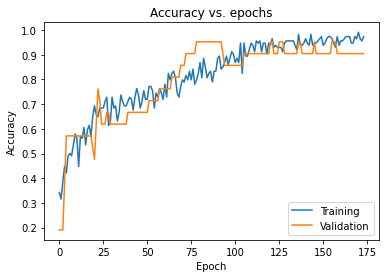

In [108]:
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

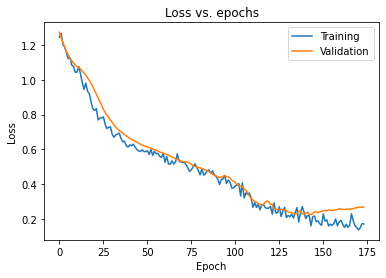

In [109]:
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Evaluate model

In [110]:
test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.206
Test accuracy: 93.33%
